# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import json
import logging

import optuna

import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

from bb_energy_prediction import models, data_utils, train, evaluate

c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.
The preprocessing steps are based on data analysis done in the data exploration notebook

In [2]:
data_df = data_utils.get_data_df(data_path="../energy_data/data.pkl")

In [3]:
data_df.sample(10)

,bb,energy,program_name,bb_embeddings
471280,"[movq %rax, add $0x10 %rsp, popq %rbx, jmp %rax]",0.324511,variable_name_results,"[[0.8586008, 0.37870914, 2.0187523, -0.8874969..."
228923,[jnz 0x9],0.130498,ip_results,"[[3.0867841, 0.045241714, -0.47935292, -3.4551..."
388102,"[movq %rdi, movl %eax, sub $0x1 %eax, movl %ea...",0.324511,variable_name_results,"[[0.8586008, 0.37870914, 2.0187523, -0.8874969..."
68694,"[xor %r15d %r15d, jmp]",0.132559,find_biggest_results,"[[1.2275966, -0.37075263, -0.51339054, -0.2035..."
397664,"[mov %rdx %rax, popq %rbx, retq]",0.151438,variable_name_results,"[[2.5854802, -0.6781732, 0.8800236, 0.4501543,..."
530661,"[lea %rax, movq %rax, movb %bl (%rdx), movl (%...",0.411048,variable_name_results,"[[0.78969884, 2.191178, 0.6428773, -1.0424049,..."
323520,"[movzxb (%rsi) %ecx, movb %cl (%rdi), retq]",0.644934,swap_results,"[[2.159594, 1.5811423, 2.199826, 1.6092503, 1...."
109322,"[movzx %al %esi, mov %r14 %rdi, lea %rbx, sub ...",0.023618,find_dyn_sum_results,"[[0.58858556, 0.64843124, -0.7376701, 1.921198..."
142449,"[test %r8d %r8d, js 0xa85]",0.282755,function_pointer_results,"[[1.5844374, 1.2708944, 1.649587, 1.2504534, 0..."
184836,"[movq %rax, mov %rcx, sub %rcx, mov %rax %rdx,...",0.617918,ip_get_results,"[[0.85860157, 0.3787081, 2.0187519, -0.8874969..."


In [4]:
program_names = data_df.program_name.value_counts().index[4:]
test_programs = np.random.choice(program_names, 3, replace=False)
train_val_df = data_df[~data_df.program_name.isin(test_programs)]
test_df = data_df[data_df.program_name.isin(test_programs)]

print(f"Test programs: {test_programs}")
print(f"Test data size: {len(test_df)}")

Test programs: ['bin_to_dec_results' 'game_of_life_results' 'polinominal_results']
Test data size: 21674


# LSTM Model

## Optuna Trials

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-regression-bigger-val-study"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/palmtee-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Max instructions", 20)
study.set_user_attr("Training-val data", len(train_val_df))
study.set_user_attr("Testing programs", test_programs.tolist())

[I 2023-02-10 13:49:50,022] A new study created in RDB with name: lstm-regression-bigger-val-study


A new study created in RDB with name: lstm-regression-bigger-val-study


In [ ]:
def objective(trial):
    
    lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    dense_size = trial.suggest_int("dense_size", 16, 256)
    smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
    batch_size = trial.suggest_int("batch_size", 128, 768)
    lr = trial.suggest_float("lr", 5e-4, 1e-2)
    lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
    dense_dropout = trial.suggest_float("dense_dropout", 0, 0.2)

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=False,
        batch_size=batch_size,
        split=0.7
    )
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        dense_dropout=dense_dropout,
    )
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=50,
        batch_size=batch_size,
        early_stopping=True,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]

study.optimize(objective, n_trials=50)

[I 2023-02-10 13:58:32,458] Trial 0 finished with value: 0.582876705504083 and parameters: {'lstm_layers': 1, 'hidden_size': 36, 'dense_size': 32, 'smaller_dense_size': 50, 'batch_size': 620, 'lr': 0.00164694279164158, 'lstm_dropout': 0.06584800352884339, 'dense_dropout': 0.05676527433317433}. Best is trial 0 with value: 0.582876705504083.


Trial 0 finished with value: 0.582876705504083 and parameters: {'lstm_layers': 1, 'hidden_size': 36, 'dense_size': 32, 'smaller_dense_size': 50, 'batch_size': 620, 'lr': 0.00164694279164158, 'lstm_dropout': 0.06584800352884339, 'dense_dropout': 0.05676527433317433}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 14:01:37,075] Trial 1 finished with value: 0.5981230641913227 and parameters: {'lstm_layers': 3, 'hidden_size': 35, 'dense_size': 114, 'smaller_dense_size': 29, 'batch_size': 376, 'lr': 0.00796580262940179, 'lstm_dropout': 0.13751794808032022, 'dense_dropout': 0.17564062860391097}. Best is trial 0 with value: 0.582876705504083.


Trial 1 finished with value: 0.5981230641913227 and parameters: {'lstm_layers': 3, 'hidden_size': 35, 'dense_size': 114, 'smaller_dense_size': 29, 'batch_size': 376, 'lr': 0.00796580262940179, 'lstm_dropout': 0.13751794808032022, 'dense_dropout': 0.17564062860391097}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 14:10:09,210] Trial 2 finished with value: 0.5915926234589682 and parameters: {'lstm_layers': 1, 'hidden_size': 20, 'dense_size': 240, 'smaller_dense_size': 33, 'batch_size': 530, 'lr': 0.005318819527559984, 'lstm_dropout': 0.09325143525230147, 'dense_dropout': 0.19881791745994426}. Best is trial 0 with value: 0.582876705504083.


Trial 2 finished with value: 0.5915926234589682 and parameters: {'lstm_layers': 1, 'hidden_size': 20, 'dense_size': 240, 'smaller_dense_size': 33, 'batch_size': 530, 'lr': 0.005318819527559984, 'lstm_dropout': 0.09325143525230147, 'dense_dropout': 0.19881791745994426}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 14:18:15,610] Trial 3 finished with value: 0.5850794100586105 and parameters: {'lstm_layers': 2, 'hidden_size': 22, 'dense_size': 156, 'smaller_dense_size': 42, 'batch_size': 697, 'lr': 0.0032721627415744103, 'lstm_dropout': 0.11109955070300122, 'dense_dropout': 0.012920147111555091}. Best is trial 0 with value: 0.582876705504083.


Trial 3 finished with value: 0.5850794100586105 and parameters: {'lstm_layers': 2, 'hidden_size': 22, 'dense_size': 156, 'smaller_dense_size': 42, 'batch_size': 697, 'lr': 0.0032721627415744103, 'lstm_dropout': 0.11109955070300122, 'dense_dropout': 0.012920147111555091}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 14:30:57,588] Trial 4 finished with value: 0.5907070684432983 and parameters: {'lstm_layers': 3, 'hidden_size': 111, 'dense_size': 68, 'smaller_dense_size': 31, 'batch_size': 639, 'lr': 0.006148644830569835, 'lstm_dropout': 0.13349534602791507, 'dense_dropout': 0.03811162637744092}. Best is trial 0 with value: 0.582876705504083.


Trial 4 finished with value: 0.5907070684432983 and parameters: {'lstm_layers': 3, 'hidden_size': 111, 'dense_size': 68, 'smaller_dense_size': 31, 'batch_size': 639, 'lr': 0.006148644830569835, 'lstm_dropout': 0.13349534602791507, 'dense_dropout': 0.03811162637744092}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 14:40:51,959] Trial 5 finished with value: 0.5831392582197835 and parameters: {'lstm_layers': 1, 'hidden_size': 33, 'dense_size': 57, 'smaller_dense_size': 50, 'batch_size': 358, 'lr': 0.003691061192279227, 'lstm_dropout': 0.14193681439146558, 'dense_dropout': 0.0304660356647549}. Best is trial 0 with value: 0.582876705504083.


Trial 5 finished with value: 0.5831392582197835 and parameters: {'lstm_layers': 1, 'hidden_size': 33, 'dense_size': 57, 'smaller_dense_size': 50, 'batch_size': 358, 'lr': 0.003691061192279227, 'lstm_dropout': 0.14193681439146558, 'dense_dropout': 0.0304660356647549}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 14:48:46,287] Trial 6 finished with value: 0.5915150234387034 and parameters: {'lstm_layers': 1, 'hidden_size': 97, 'dense_size': 25, 'smaller_dense_size': 62, 'batch_size': 570, 'lr': 0.009892650092616468, 'lstm_dropout': 0.0405375992313684, 'dense_dropout': 0.06123315935099294}. Best is trial 0 with value: 0.582876705504083.


Trial 6 finished with value: 0.5915150234387034 and parameters: {'lstm_layers': 1, 'hidden_size': 97, 'dense_size': 25, 'smaller_dense_size': 62, 'batch_size': 570, 'lr': 0.009892650092616468, 'lstm_dropout': 0.0405375992313684, 'dense_dropout': 0.06123315935099294}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 14:51:24,324] Trial 7 finished with value: 0.6190773006880058 and parameters: {'lstm_layers': 3, 'hidden_size': 19, 'dense_size': 103, 'smaller_dense_size': 34, 'batch_size': 451, 'lr': 0.008047874444279941, 'lstm_dropout': 0.05287848514225651, 'dense_dropout': 0.050383608596218404}. Best is trial 0 with value: 0.582876705504083.


Trial 7 finished with value: 0.6190773006880058 and parameters: {'lstm_layers': 3, 'hidden_size': 19, 'dense_size': 103, 'smaller_dense_size': 34, 'batch_size': 451, 'lr': 0.008047874444279941, 'lstm_dropout': 0.05287848514225651, 'dense_dropout': 0.050383608596218404}. Best is trial 0 with value: 0.582876705504083.


[I 2023-02-10 15:04:56,087] Trial 8 finished with value: 0.5793674052771876 and parameters: {'lstm_layers': 3, 'hidden_size': 97, 'dense_size': 241, 'smaller_dense_size': 63, 'batch_size': 406, 'lr': 0.007813293629841692, 'lstm_dropout': 0.03769721904775967, 'dense_dropout': 0.17356885726275992}. Best is trial 8 with value: 0.5793674052771876.


Trial 8 finished with value: 0.5793674052771876 and parameters: {'lstm_layers': 3, 'hidden_size': 97, 'dense_size': 241, 'smaller_dense_size': 63, 'batch_size': 406, 'lr': 0.007813293629841692, 'lstm_dropout': 0.03769721904775967, 'dense_dropout': 0.17356885726275992}. Best is trial 8 with value: 0.5793674052771876.


[I 2023-02-10 15:12:24,641] Trial 9 finished with value: 0.5868139279925305 and parameters: {'lstm_layers': 2, 'hidden_size': 17, 'dense_size': 97, 'smaller_dense_size': 35, 'batch_size': 693, 'lr': 0.00545336204147099, 'lstm_dropout': 0.029854626413045194, 'dense_dropout': 0.1822712669492357}. Best is trial 8 with value: 0.5793674052771876.


Trial 9 finished with value: 0.5868139279925305 and parameters: {'lstm_layers': 2, 'hidden_size': 17, 'dense_size': 97, 'smaller_dense_size': 35, 'batch_size': 693, 'lr': 0.00545336204147099, 'lstm_dropout': 0.029854626413045194, 'dense_dropout': 0.1822712669492357}. Best is trial 8 with value: 0.5793674052771876.


[I 2023-02-10 15:33:57,478] Trial 10 finished with value: 0.5676721705309448 and parameters: {'lstm_layers': 3, 'hidden_size': 74, 'dense_size': 256, 'smaller_dense_size': 13, 'batch_size': 154, 'lr': 0.0005929957804749458, 'lstm_dropout': 0.004232413684304409, 'dense_dropout': 0.13724871841598169}. Best is trial 10 with value: 0.5676721705309448.


Trial 10 finished with value: 0.5676721705309448 and parameters: {'lstm_layers': 3, 'hidden_size': 74, 'dense_size': 256, 'smaller_dense_size': 13, 'batch_size': 154, 'lr': 0.0005929957804749458, 'lstm_dropout': 0.004232413684304409, 'dense_dropout': 0.13724871841598169}. Best is trial 10 with value: 0.5676721705309448.


[I 2023-02-10 15:54:30,733] Trial 11 finished with value: 0.5578545135530558 and parameters: {'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 253, 'smaller_dense_size': 8, 'batch_size': 128, 'lr': 0.000809272082290665, 'lstm_dropout': 0.00431296522116943, 'dense_dropout': 0.135769034622565}. Best is trial 11 with value: 0.5578545135530558.


Trial 11 finished with value: 0.5578545135530558 and parameters: {'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 253, 'smaller_dense_size': 8, 'batch_size': 128, 'lr': 0.000809272082290665, 'lstm_dropout': 0.00431296522116943, 'dense_dropout': 0.135769034622565}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 16:14:56,440] Trial 12 finished with value: 0.562584276266501 and parameters: {'lstm_layers': 2, 'hidden_size': 68, 'dense_size': 189, 'smaller_dense_size': 9, 'batch_size': 135, 'lr': 0.0006443634923105294, 'lstm_dropout': 0.0012371284815468203, 'dense_dropout': 0.12337212305651993}. Best is trial 11 with value: 0.5578545135530558.


Trial 12 finished with value: 0.562584276266501 and parameters: {'lstm_layers': 2, 'hidden_size': 68, 'dense_size': 189, 'smaller_dense_size': 9, 'batch_size': 135, 'lr': 0.0006443634923105294, 'lstm_dropout': 0.0012371284815468203, 'dense_dropout': 0.12337212305651993}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 16:36:42,549] Trial 13 finished with value: 0.5641466352656845 and parameters: {'lstm_layers': 2, 'hidden_size': 63, 'dense_size': 191, 'smaller_dense_size': 8, 'batch_size': 129, 'lr': 0.0007922372003534281, 'lstm_dropout': 0.006141645544597039, 'dense_dropout': 0.10441065425849047}. Best is trial 11 with value: 0.5578545135530558.


Trial 13 finished with value: 0.5641466352656845 and parameters: {'lstm_layers': 2, 'hidden_size': 63, 'dense_size': 191, 'smaller_dense_size': 8, 'batch_size': 129, 'lr': 0.0007922372003534281, 'lstm_dropout': 0.006141645544597039, 'dense_dropout': 0.10441065425849047}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 16:47:45,425] Trial 14 finished with value: 0.5763580696705061 and parameters: {'lstm_layers': 2, 'hidden_size': 62, 'dense_size': 197, 'smaller_dense_size': 19, 'batch_size': 245, 'lr': 0.0020530831035792813, 'lstm_dropout': 0.16912826703647338, 'dense_dropout': 0.13165278708515193}. Best is trial 11 with value: 0.5578545135530558.


Trial 14 finished with value: 0.5763580696705061 and parameters: {'lstm_layers': 2, 'hidden_size': 62, 'dense_size': 197, 'smaller_dense_size': 19, 'batch_size': 245, 'lr': 0.0020530831035792813, 'lstm_dropout': 0.16912826703647338, 'dense_dropout': 0.13165278708515193}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 17:01:49,717] Trial 15 finished with value: 0.5964674905956727 and parameters: {'lstm_layers': 2, 'hidden_size': 78, 'dense_size': 201, 'smaller_dense_size': 21, 'batch_size': 250, 'lr': 0.0024103736912709332, 'lstm_dropout': 0.00713488933369999, 'dense_dropout': 0.09296503770343909}. Best is trial 11 with value: 0.5578545135530558.


Trial 15 finished with value: 0.5964674905956727 and parameters: {'lstm_layers': 2, 'hidden_size': 78, 'dense_size': 201, 'smaller_dense_size': 21, 'batch_size': 250, 'lr': 0.0024103736912709332, 'lstm_dropout': 0.00713488933369999, 'dense_dropout': 0.09296503770343909}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 17:07:51,382] Trial 16 finished with value: 0.5951162130346795 and parameters: {'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 158, 'smaller_dense_size': 8, 'batch_size': 227, 'lr': 0.0006915104008329386, 'lstm_dropout': 0.07300228307440469, 'dense_dropout': 0.14132714229105267}. Best is trial 11 with value: 0.5578545135530558.


Trial 16 finished with value: 0.5951162130346795 and parameters: {'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 158, 'smaller_dense_size': 8, 'batch_size': 227, 'lr': 0.0006915104008329386, 'lstm_dropout': 0.07300228307440469, 'dense_dropout': 0.14132714229105267}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 17:23:53,004] Trial 17 finished with value: 0.5749665307692993 and parameters: {'lstm_layers': 3, 'hidden_size': 128, 'dense_size': 220, 'smaller_dense_size': 21, 'batch_size': 307, 'lr': 0.003693293693792528, 'lstm_dropout': 0.021613129630849548, 'dense_dropout': 0.10526450811700261}. Best is trial 11 with value: 0.5578545135530558.


Trial 17 finished with value: 0.5749665307692993 and parameters: {'lstm_layers': 3, 'hidden_size': 128, 'dense_size': 220, 'smaller_dense_size': 21, 'batch_size': 307, 'lr': 0.003693293693792528, 'lstm_dropout': 0.021613129630849548, 'dense_dropout': 0.10526450811700261}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 17:40:32,992] Trial 18 finished with value: 0.5655620827736607 and parameters: {'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 168, 'smaller_dense_size': 16, 'batch_size': 191, 'lr': 0.0016075606391600529, 'lstm_dropout': 0.021845198880529763, 'dense_dropout': 0.08527753090169621}. Best is trial 11 with value: 0.5578545135530558.


Trial 18 finished with value: 0.5655620827736607 and parameters: {'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 168, 'smaller_dense_size': 16, 'batch_size': 191, 'lr': 0.0016075606391600529, 'lstm_dropout': 0.021845198880529763, 'dense_dropout': 0.08527753090169621}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 17:47:21,936] Trial 19 finished with value: 0.585480892771407 and parameters: {'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 220, 'smaller_dense_size': 24, 'batch_size': 302, 'lr': 0.0030480950719439658, 'lstm_dropout': 0.0013153947060182483, 'dense_dropout': 0.1527629839378098}. Best is trial 11 with value: 0.5578545135530558.


Trial 19 finished with value: 0.585480892771407 and parameters: {'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 220, 'smaller_dense_size': 24, 'batch_size': 302, 'lr': 0.0030480950719439658, 'lstm_dropout': 0.0013153947060182483, 'dense_dropout': 0.1527629839378098}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 17:56:38,527] Trial 20 finished with value: 0.5910141477361321 and parameters: {'lstm_layers': 3, 'hidden_size': 82, 'dense_size': 133, 'smaller_dense_size': 12, 'batch_size': 496, 'lr': 0.0024463123987465162, 'lstm_dropout': 0.05062538510853996, 'dense_dropout': 0.11949552537177473}. Best is trial 11 with value: 0.5578545135530558.


Trial 20 finished with value: 0.5910141477361321 and parameters: {'lstm_layers': 3, 'hidden_size': 82, 'dense_size': 133, 'smaller_dense_size': 12, 'batch_size': 496, 'lr': 0.0024463123987465162, 'lstm_dropout': 0.05062538510853996, 'dense_dropout': 0.11949552537177473}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 18:12:46,024] Trial 21 finished with value: 0.5692597731773616 and parameters: {'lstm_layers': 2, 'hidden_size': 62, 'dense_size': 180, 'smaller_dense_size': 8, 'batch_size': 140, 'lr': 0.0006424609627500211, 'lstm_dropout': 0.020549640818512523, 'dense_dropout': 0.11494941450612627}. Best is trial 11 with value: 0.5578545135530558.


Trial 21 finished with value: 0.5692597731773616 and parameters: {'lstm_layers': 2, 'hidden_size': 62, 'dense_size': 180, 'smaller_dense_size': 8, 'batch_size': 140, 'lr': 0.0006424609627500211, 'lstm_dropout': 0.020549640818512523, 'dense_dropout': 0.11494941450612627}. Best is trial 11 with value: 0.5578545135530558.


[I 2023-02-10 18:34:11,473] Trial 22 finished with value: 0.5434756916263261 and parameters: {'lstm_layers': 2, 'hidden_size': 70, 'dense_size': 196, 'smaller_dense_size': 14, 'batch_size': 138, 'lr': 0.0012370135236163147, 'lstm_dropout': 0.0023665864318416466, 'dense_dropout': 0.08181233624118837}. Best is trial 22 with value: 0.5434756916263261.


Trial 22 finished with value: 0.5434756916263261 and parameters: {'lstm_layers': 2, 'hidden_size': 70, 'dense_size': 196, 'smaller_dense_size': 14, 'batch_size': 138, 'lr': 0.0012370135236163147, 'lstm_dropout': 0.0023665864318416466, 'dense_dropout': 0.08181233624118837}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 18:50:31,300] Trial 23 finished with value: 0.5829280449419606 and parameters: {'lstm_layers': 2, 'hidden_size': 91, 'dense_size': 218, 'smaller_dense_size': 14, 'batch_size': 195, 'lr': 0.0016645321122616308, 'lstm_dropout': 0.030507580671705038, 'dense_dropout': 0.08057855345384196}. Best is trial 22 with value: 0.5434756916263261.


Trial 23 finished with value: 0.5829280449419606 and parameters: {'lstm_layers': 2, 'hidden_size': 91, 'dense_size': 218, 'smaller_dense_size': 14, 'batch_size': 195, 'lr': 0.0016645321122616308, 'lstm_dropout': 0.030507580671705038, 'dense_dropout': 0.08057855345384196}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 19:01:58,543] Trial 24 finished with value: 0.5687586644664406 and parameters: {'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 146, 'smaller_dense_size': 26, 'batch_size': 299, 'lr': 0.0013188669496029953, 'lstm_dropout': 0.0009798002162479944, 'dense_dropout': 0.07679588384800186}. Best is trial 22 with value: 0.5434756916263261.


Trial 24 finished with value: 0.5687586644664406 and parameters: {'lstm_layers': 2, 'hidden_size': 49, 'dense_size': 146, 'smaller_dense_size': 26, 'batch_size': 299, 'lr': 0.0013188669496029953, 'lstm_dropout': 0.0009798002162479944, 'dense_dropout': 0.07679588384800186}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 19:16:11,519] Trial 25 finished with value: 0.5565057805639954 and parameters: {'lstm_layers': 1, 'hidden_size': 72, 'dense_size': 238, 'smaller_dense_size': 16, 'batch_size': 189, 'lr': 0.0012106754895483992, 'lstm_dropout': 0.020106696130306273, 'dense_dropout': 0.11916706943315003}. Best is trial 22 with value: 0.5434756916263261.


Trial 25 finished with value: 0.5565057805639954 and parameters: {'lstm_layers': 1, 'hidden_size': 72, 'dense_size': 238, 'smaller_dense_size': 16, 'batch_size': 189, 'lr': 0.0012106754895483992, 'lstm_dropout': 0.020106696130306273, 'dense_dropout': 0.11916706943315003}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 19:30:29,664] Trial 26 finished with value: 0.5683638868378658 and parameters: {'lstm_layers': 1, 'hidden_size': 107, 'dense_size': 252, 'smaller_dense_size': 17, 'batch_size': 188, 'lr': 0.0026566534962620013, 'lstm_dropout': 0.0203269964482053, 'dense_dropout': 0.09906711910514779}. Best is trial 22 with value: 0.5434756916263261.


Trial 26 finished with value: 0.5683638868378658 and parameters: {'lstm_layers': 1, 'hidden_size': 107, 'dense_size': 252, 'smaller_dense_size': 17, 'batch_size': 188, 'lr': 0.0026566534962620013, 'lstm_dropout': 0.0203269964482053, 'dense_dropout': 0.09906711910514779}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 19:37:51,245] Trial 27 finished with value: 0.5831266982901481 and parameters: {'lstm_layers': 1, 'hidden_size': 74, 'dense_size': 231, 'smaller_dense_size': 23, 'batch_size': 764, 'lr': 0.004100057393160321, 'lstm_dropout': 0.0500138434168164, 'dense_dropout': 0.1482696908744015}. Best is trial 22 with value: 0.5434756916263261.


Trial 27 finished with value: 0.5831266982901481 and parameters: {'lstm_layers': 1, 'hidden_size': 74, 'dense_size': 231, 'smaller_dense_size': 23, 'batch_size': 764, 'lr': 0.004100057393160321, 'lstm_dropout': 0.0500138434168164, 'dense_dropout': 0.1482696908744015}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 19:48:23,385] Trial 28 finished with value: 0.585511645419257 and parameters: {'lstm_layers': 1, 'hidden_size': 46, 'dense_size': 208, 'smaller_dense_size': 27, 'batch_size': 274, 'lr': 0.0013608765020679257, 'lstm_dropout': 0.01603003491222328, 'dense_dropout': 0.11385391117072793}. Best is trial 22 with value: 0.5434756916263261.


Trial 28 finished with value: 0.585511645419257 and parameters: {'lstm_layers': 1, 'hidden_size': 46, 'dense_size': 208, 'smaller_dense_size': 27, 'batch_size': 274, 'lr': 0.0013608765020679257, 'lstm_dropout': 0.01603003491222328, 'dense_dropout': 0.11385391117072793}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 19:59:34,798] Trial 29 finished with value: 0.5682824484430826 and parameters: {'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 231, 'smaller_dense_size': 17, 'batch_size': 184, 'lr': 0.002128319967353789, 'lstm_dropout': 0.06761431146972964, 'dense_dropout': 0.1541375055947035}. Best is trial 22 with value: 0.5434756916263261.


Trial 29 finished with value: 0.5682824484430826 and parameters: {'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 231, 'smaller_dense_size': 17, 'batch_size': 184, 'lr': 0.002128319967353789, 'lstm_dropout': 0.06761431146972964, 'dense_dropout': 0.1541375055947035}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 20:11:53,811] Trial 30 finished with value: 0.5724854697572425 and parameters: {'lstm_layers': 3, 'hidden_size': 70, 'dense_size': 177, 'smaller_dense_size': 39, 'batch_size': 339, 'lr': 0.00131838651662177, 'lstm_dropout': 0.039062607037419705, 'dense_dropout': 0.07093478498997666}. Best is trial 22 with value: 0.5434756916263261.


Trial 30 finished with value: 0.5724854697572425 and parameters: {'lstm_layers': 3, 'hidden_size': 70, 'dense_size': 177, 'smaller_dense_size': 39, 'batch_size': 339, 'lr': 0.00131838651662177, 'lstm_dropout': 0.039062607037419705, 'dense_dropout': 0.07093478498997666}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 20:24:16,421] Trial 31 finished with value: 0.5827578175008495 and parameters: {'lstm_layers': 1, 'hidden_size': 68, 'dense_size': 188, 'smaller_dense_size': 12, 'batch_size': 159, 'lr': 0.0018569762909661776, 'lstm_dropout': 2.6756773026409553e-05, 'dense_dropout': 0.12787023455396446}. Best is trial 22 with value: 0.5434756916263261.


Trial 31 finished with value: 0.5827578175008495 and parameters: {'lstm_layers': 1, 'hidden_size': 68, 'dense_size': 188, 'smaller_dense_size': 12, 'batch_size': 159, 'lr': 0.0018569762909661776, 'lstm_dropout': 2.6756773026409553e-05, 'dense_dropout': 0.12787023455396446}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 20:32:06,562] Trial 32 finished with value: 0.573798896522697 and parameters: {'lstm_layers': 2, 'hidden_size': 57, 'dense_size': 213, 'smaller_dense_size': 11, 'batch_size': 220, 'lr': 0.0010958206657469573, 'lstm_dropout': 0.014416367009042808, 'dense_dropout': 0.12300313405111238}. Best is trial 22 with value: 0.5434756916263261.


Trial 32 finished with value: 0.573798896522697 and parameters: {'lstm_layers': 2, 'hidden_size': 57, 'dense_size': 213, 'smaller_dense_size': 11, 'batch_size': 220, 'lr': 0.0010958206657469573, 'lstm_dropout': 0.014416367009042808, 'dense_dropout': 0.12300313405111238}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 20:56:27,146] Trial 33 finished with value: 0.5700915625075931 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 241, 'smaller_dense_size': 15, 'batch_size': 130, 'lr': 0.0005186690716647854, 'lstm_dropout': 0.028053893138165066, 'dense_dropout': 0.09379137935739762}. Best is trial 22 with value: 0.5434756916263261.


Trial 33 finished with value: 0.5700915625075931 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 241, 'smaller_dense_size': 15, 'batch_size': 130, 'lr': 0.0005186690716647854, 'lstm_dropout': 0.028053893138165066, 'dense_dropout': 0.09379137935739762}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 21:15:36,211] Trial 34 finished with value: 0.5733718258370921 and parameters: {'lstm_layers': 2, 'hidden_size': 69, 'dense_size': 247, 'smaller_dense_size': 9, 'batch_size': 167, 'lr': 0.0011655344849805342, 'lstm_dropout': 0.014105388241532173, 'dense_dropout': 0.11608721694136999}. Best is trial 22 with value: 0.5434756916263261.


Trial 34 finished with value: 0.5733718258370921 and parameters: {'lstm_layers': 2, 'hidden_size': 69, 'dense_size': 247, 'smaller_dense_size': 9, 'batch_size': 167, 'lr': 0.0011655344849805342, 'lstm_dropout': 0.014105388241532173, 'dense_dropout': 0.11608721694136999}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 21:28:07,333] Trial 35 finished with value: 0.5760472394801952 and parameters: {'lstm_layers': 1, 'hidden_size': 43, 'dense_size': 224, 'smaller_dense_size': 19, 'batch_size': 222, 'lr': 0.0018019680657172664, 'lstm_dropout': 0.011446013661650628, 'dense_dropout': 0.10866641078544115}. Best is trial 22 with value: 0.5434756916263261.


Trial 35 finished with value: 0.5760472394801952 and parameters: {'lstm_layers': 1, 'hidden_size': 43, 'dense_size': 224, 'smaller_dense_size': 19, 'batch_size': 222, 'lr': 0.0018019680657172664, 'lstm_dropout': 0.011446013661650628, 'dense_dropout': 0.10866641078544115}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 21:53:40,356] Trial 36 finished with value: 0.5769074679068897 and parameters: {'lstm_layers': 3, 'hidden_size': 34, 'dense_size': 122, 'smaller_dense_size': 44, 'batch_size': 130, 'lr': 0.0025877101020587694, 'lstm_dropout': 0.07951109391438217, 'dense_dropout': 0.12763415984082457}. Best is trial 22 with value: 0.5434756916263261.


Trial 36 finished with value: 0.5769074679068897 and parameters: {'lstm_layers': 3, 'hidden_size': 34, 'dense_size': 122, 'smaller_dense_size': 44, 'batch_size': 130, 'lr': 0.0025877101020587694, 'lstm_dropout': 0.07951109391438217, 'dense_dropout': 0.12763415984082457}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 22:08:15,736] Trial 37 finished with value: 0.5542405850157656 and parameters: {'lstm_layers': 2, 'hidden_size': 56, 'dense_size': 205, 'smaller_dense_size': 29, 'batch_size': 206, 'lr': 0.0011042415743139754, 'lstm_dropout': 0.057041279372737036, 'dense_dropout': 0.09065332496936009}. Best is trial 22 with value: 0.5434756916263261.


Trial 37 finished with value: 0.5542405850157656 and parameters: {'lstm_layers': 2, 'hidden_size': 56, 'dense_size': 205, 'smaller_dense_size': 29, 'batch_size': 206, 'lr': 0.0011042415743139754, 'lstm_dropout': 0.057041279372737036, 'dense_dropout': 0.09065332496936009}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 22:12:53,021] Trial 38 finished with value: 0.5773470095416021 and parameters: {'lstm_layers': 1, 'hidden_size': 55, 'dense_size': 236, 'smaller_dense_size': 48, 'batch_size': 267, 'lr': 0.0030989879342141757, 'lstm_dropout': 0.06030566012858755, 'dense_dropout': 0.08846822141717628}. Best is trial 22 with value: 0.5434756916263261.


Trial 38 finished with value: 0.5773470095416021 and parameters: {'lstm_layers': 1, 'hidden_size': 55, 'dense_size': 236, 'smaller_dense_size': 48, 'batch_size': 267, 'lr': 0.0030989879342141757, 'lstm_dropout': 0.06030566012858755, 'dense_dropout': 0.08846822141717628}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 22:22:35,813] Trial 39 finished with value: 0.5766937886514971 and parameters: {'lstm_layers': 2, 'hidden_size': 41, 'dense_size': 206, 'smaller_dense_size': 30, 'batch_size': 385, 'lr': 0.002068059823458694, 'lstm_dropout': 0.04081235984300066, 'dense_dropout': 0.06031788890244738}. Best is trial 22 with value: 0.5434756916263261.


Trial 39 finished with value: 0.5766937886514971 and parameters: {'lstm_layers': 2, 'hidden_size': 41, 'dense_size': 206, 'smaller_dense_size': 30, 'batch_size': 385, 'lr': 0.002068059823458694, 'lstm_dropout': 0.04081235984300066, 'dense_dropout': 0.06031788890244738}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 22:32:26,629] Trial 40 finished with value: 0.5736894290204402 and parameters: {'lstm_layers': 3, 'hidden_size': 9, 'dense_size': 256, 'smaller_dense_size': 55, 'batch_size': 441, 'lr': 0.0012903099556589546, 'lstm_dropout': 0.09025232705357449, 'dense_dropout': 0.07324029958319869}. Best is trial 22 with value: 0.5434756916263261.


Trial 40 finished with value: 0.5736894290204402 and parameters: {'lstm_layers': 3, 'hidden_size': 9, 'dense_size': 256, 'smaller_dense_size': 55, 'batch_size': 441, 'lr': 0.0012903099556589546, 'lstm_dropout': 0.09025232705357449, 'dense_dropout': 0.07324029958319869}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 22:48:08,942] Trial 41 finished with value: 0.5655498563985288 and parameters: {'lstm_layers': 2, 'hidden_size': 63, 'dense_size': 166, 'smaller_dense_size': 11, 'batch_size': 207, 'lr': 0.0009363143724500003, 'lstm_dropout': 0.03168362242713933, 'dense_dropout': 0.1023100737705287}. Best is trial 22 with value: 0.5434756916263261.


Trial 41 finished with value: 0.5655498563985288 and parameters: {'lstm_layers': 2, 'hidden_size': 63, 'dense_size': 166, 'smaller_dense_size': 11, 'batch_size': 207, 'lr': 0.0009363143724500003, 'lstm_dropout': 0.03168362242713933, 'dense_dropout': 0.1023100737705287}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 23:06:24,755] Trial 42 finished with value: 0.5643170882735336 and parameters: {'lstm_layers': 2, 'hidden_size': 75, 'dense_size': 230, 'smaller_dense_size': 14, 'batch_size': 168, 'lr': 0.0005251204555413286, 'lstm_dropout': 0.010612933456454834, 'dense_dropout': 0.09534173611634218}. Best is trial 22 with value: 0.5434756916263261.


Trial 42 finished with value: 0.5643170882735336 and parameters: {'lstm_layers': 2, 'hidden_size': 75, 'dense_size': 230, 'smaller_dense_size': 14, 'batch_size': 168, 'lr': 0.0005251204555413286, 'lstm_dropout': 0.010612933456454834, 'dense_dropout': 0.09534173611634218}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 23:20:09,541] Trial 43 finished with value: 0.563319828999894 and parameters: {'lstm_layers': 2, 'hidden_size': 69, 'dense_size': 190, 'smaller_dense_size': 19, 'batch_size': 171, 'lr': 0.001583360995965636, 'lstm_dropout': 0.0262156030261816, 'dense_dropout': 0.138411085873397}. Best is trial 22 with value: 0.5434756916263261.


Trial 43 finished with value: 0.563319828999894 and parameters: {'lstm_layers': 2, 'hidden_size': 69, 'dense_size': 190, 'smaller_dense_size': 19, 'batch_size': 171, 'lr': 0.001583360995965636, 'lstm_dropout': 0.0262156030261816, 'dense_dropout': 0.138411085873397}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 23:30:54,238] Trial 44 finished with value: 0.5729740708332344 and parameters: {'lstm_layers': 2, 'hidden_size': 79, 'dense_size': 180, 'smaller_dense_size': 37, 'batch_size': 236, 'lr': 0.0009441123541133643, 'lstm_dropout': 0.011803372376009225, 'dense_dropout': 0.1117266705678622}. Best is trial 22 with value: 0.5434756916263261.


Trial 44 finished with value: 0.5729740708332344 and parameters: {'lstm_layers': 2, 'hidden_size': 79, 'dense_size': 180, 'smaller_dense_size': 37, 'batch_size': 236, 'lr': 0.0009441123541133643, 'lstm_dropout': 0.011803372376009225, 'dense_dropout': 0.1117266705678622}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 23:37:58,993] Trial 45 finished with value: 0.5854874724565551 and parameters: {'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 69, 'smaller_dense_size': 10, 'batch_size': 555, 'lr': 0.0009781201746396385, 'lstm_dropout': 0.04258938285299544, 'dense_dropout': 0.08584982281290116}. Best is trial 22 with value: 0.5434756916263261.


Trial 45 finished with value: 0.5854874724565551 and parameters: {'lstm_layers': 2, 'hidden_size': 104, 'dense_size': 69, 'smaller_dense_size': 10, 'batch_size': 555, 'lr': 0.0009781201746396385, 'lstm_dropout': 0.04258938285299544, 'dense_dropout': 0.08584982281290116}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-10 23:56:13,240] Trial 46 finished with value: 0.5691554096464913 and parameters: {'lstm_layers': 2, 'hidden_size': 57, 'dense_size': 202, 'smaller_dense_size': 28, 'batch_size': 153, 'lr': 0.0020772880001183737, 'lstm_dropout': 0.0007071591157461104, 'dense_dropout': 0.04751892384032532}. Best is trial 22 with value: 0.5434756916263261.


Trial 46 finished with value: 0.5691554096464913 and parameters: {'lstm_layers': 2, 'hidden_size': 57, 'dense_size': 202, 'smaller_dense_size': 28, 'batch_size': 153, 'lr': 0.0020772880001183737, 'lstm_dropout': 0.0007071591157461104, 'dense_dropout': 0.04751892384032532}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-11 00:11:19,319] Trial 47 finished with value: 0.5780228702874666 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 242, 'smaller_dense_size': 32, 'batch_size': 269, 'lr': 0.0016044735973016282, 'lstm_dropout': 0.02886745472035137, 'dense_dropout': 0.12274605293791774}. Best is trial 22 with value: 0.5434756916263261.


Trial 47 finished with value: 0.5780228702874666 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 242, 'smaller_dense_size': 32, 'batch_size': 269, 'lr': 0.0016044735973016282, 'lstm_dropout': 0.02886745472035137, 'dense_dropout': 0.12274605293791774}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-11 00:18:38,796] Trial 48 finished with value: 0.5866125534764297 and parameters: {'lstm_layers': 1, 'hidden_size': 28, 'dense_size': 149, 'smaller_dense_size': 23, 'batch_size': 343, 'lr': 0.0005193797700601356, 'lstm_dropout': 0.008638512114429264, 'dense_dropout': 0.10251164930103977}. Best is trial 22 with value: 0.5434756916263261.


Trial 48 finished with value: 0.5866125534764297 and parameters: {'lstm_layers': 1, 'hidden_size': 28, 'dense_size': 149, 'smaller_dense_size': 23, 'batch_size': 343, 'lr': 0.0005193797700601356, 'lstm_dropout': 0.008638512114429264, 'dense_dropout': 0.10251164930103977}. Best is trial 22 with value: 0.5434756916263261.


[I 2023-02-11 00:23:04,594] Trial 49 finished with value: 0.5873703998100909 and parameters: {'lstm_layers': 2, 'hidden_size': 52, 'dense_size': 213, 'smaller_dense_size': 16, 'batch_size': 603, 'lr': 0.0010326493002503117, 'lstm_dropout': 0.018353891478476297, 'dense_dropout': 0.13246474561249427}. Best is trial 22 with value: 0.5434756916263261.


Trial 49 finished with value: 0.5873703998100909 and parameters: {'lstm_layers': 2, 'hidden_size': 52, 'dense_size': 213, 'smaller_dense_size': 16, 'batch_size': 603, 'lr': 0.0010326493002503117, 'lstm_dropout': 0.018353891478476297, 'dense_dropout': 0.13246474561249427}. Best is trial 22 with value: 0.5434756916263261.


In [ ]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_dropout,params_dense_size,params_hidden_size,params_lr,params_lstm_dropout,params_lstm_layers,params_smaller_dense_size,state
22,22,0.543476,2023-02-10 18:12:46.029702,2023-02-10 18:34:11.459693,0 days 00:21:25.429991,138,0.081812,196,70,0.001237,0.002367,2,14,COMPLETE
37,37,0.554241,2023-02-10 21:53:40.360636,2023-02-10 22:08:15.724492,0 days 00:14:35.363856,206,0.090653,205,56,0.001104,0.057041,2,29,COMPLETE
25,25,0.556506,2023-02-10 19:01:58.548183,2023-02-10 19:16:11.505419,0 days 00:14:12.957236,189,0.119167,238,72,0.001211,0.020107,1,16,COMPLETE
11,11,0.557855,2023-02-10 15:33:57.483623,2023-02-10 15:54:30.718596,0 days 00:20:33.234973,128,0.135769,253,76,0.000809,0.004313,3,8,COMPLETE
12,12,0.562584,2023-02-10 15:54:30.738283,2023-02-10 16:14:56.425090,0 days 00:20:25.686807,135,0.123372,189,68,0.000644,0.001237,2,9,COMPLETE
43,43,0.563320,2023-02-10 23:06:24.760279,2023-02-10 23:20:09.523254,0 days 00:13:44.762975,171,0.138411,190,69,0.001583,0.026216,2,19,COMPLETE
13,13,0.564147,2023-02-10 16:14:56.445155,2023-02-10 16:36:42.534146,0 days 00:21:46.088991,129,0.104411,191,63,0.000792,0.006142,2,8,COMPLETE
42,42,0.564317,2023-02-10 22:48:08.947494,2023-02-10 23:06:24.741776,0 days 00:18:15.794282,168,0.095342,230,75,0.000525,0.010613,2,14,COMPLETE
41,41,0.565550,2023-02-10 22:32:26.634220,2023-02-10 22:48:08.929146,0 days 00:15:42.294926,207,0.102310,166,63,0.000936,0.031684,2,11,COMPLETE
18,18,0.565562,2023-02-10 17:23:53.009435,2023-02-10 17:40:32.978683,0 days 00:16:39.969248,191,0.085278,168,86,0.001608,0.021845,2,16,COMPLETE


In [ ]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size': 138, 'dense_dropout': 0.08181233624118837, 'dense_size': 196, 'hidden_size': 70, 'lr': 0.0012370135236163147, 'lstm_dropout': 0.0023665864318416466, 'lstm_layers': 2, 'smaller_dense_size': 14}, achieving val RMSE: 0.5434756916263261


## Model Training

In [ ]:
batch_size = 138

model_params = {
    "hidden_size": 70,
    "num_layers": 2,
    "dense_size": 196,
    "smaller_dense_size": 14,
    "lstm_dropout": 0.002,
    "dense_dropout": 0.08,
}

train_params = {
    "lr": 0.001,
    "epochs": 50,
    "batch_size": batch_size,
    "verbose": True,
    "early_stopping": True,
}

In [ ]:
load = False
save = True

exp_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_palmtree_models"

data_loaders = data_utils.get_data_dict(
    data_df=train_val_df,
    enc_type="palmtree",
    mean=False,
    batch_size=batch_size,
    split=0.9,
)

train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = models.LSTM_Regressor(embedding_size=embedding_size, **model_params)

if load:
    model.load_state_dict(torch.load(f"{exp_dir}/lstm_model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params,
    )

    if save:
        torch.save(train_results["model"].state_dict(), f"{exp_dir}/init_lstm_model/lstm_model")
        additional_attributes = {
            "model_params": model_params,
            "train_params": train_params,
            "loss": "RMSE",
            "number of data": len(train_loader)*batch_size,
            "test programs": test_programs.tolist(),
            "train_loss": train_results["train_loss"],
            "val_loss": train_results["val_loss"],
        }
        with open(f"{exp_dir}/init_lstm_model/additional_attributes.json", "w") as file:
            json.dump(additional_attributes, file, indent=4)

Epoch: 1/50, RMSE Train Loss: 0.59772, RMSE Val Loss: 0.58818
Epoch: 2/50, RMSE Train Loss: 0.5892, RMSE Val Loss: 0.58662
Epoch: 3/50, RMSE Train Loss: 0.58706, RMSE Val Loss: 0.58357
Epoch: 4/50, RMSE Train Loss: 0.58596, RMSE Val Loss: 0.58281
Epoch: 5/50, RMSE Train Loss: 0.58563, RMSE Val Loss: 0.58269
Epoch: 6/50, RMSE Train Loss: 0.58525, RMSE Val Loss: 0.58406
Epoch: 7/50, RMSE Train Loss: 0.58387, RMSE Val Loss: 0.58149
Epoch: 8/50, RMSE Train Loss: 0.58296, RMSE Val Loss: 0.58242
Epoch: 9/50, RMSE Train Loss: 0.58234, RMSE Val Loss: 0.58169
Epoch: 10/50, RMSE Train Loss: 0.5804, RMSE Val Loss: 0.58032
Epoch: 11/50, RMSE Train Loss: 0.5798, RMSE Val Loss: 0.57958
Epoch: 12/50, RMSE Train Loss: 0.57964, RMSE Val Loss: 0.57964
Epoch: 13/50, RMSE Train Loss: 0.57937, RMSE Val Loss: 0.58048
Epoch: 14/50, RMSE Train Loss: 0.5794, RMSE Val Loss: 0.57923
Epoch: 15/50, RMSE Train Loss: 0.57915, RMSE Val Loss: 0.58028
Epoch: 16/50, RMSE Train Loss: 0.57893, RMSE Val Loss: 0.57924
Epoch

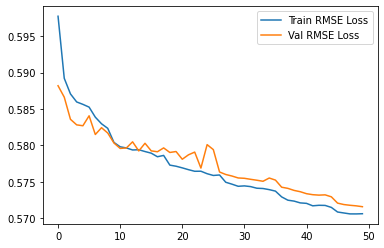

In [ ]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

## Evaluation

In [8]:
pred_dict = evaluate.evaluate(model=model, val_loader=val_loader, batch_size=batch_size)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

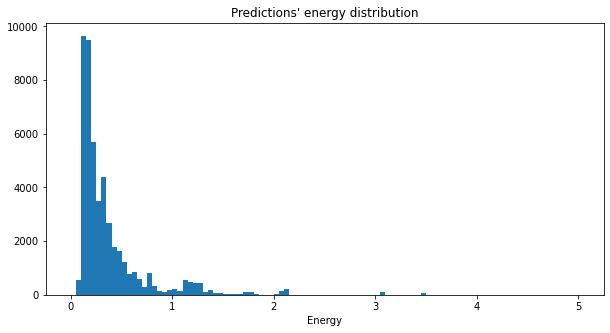

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

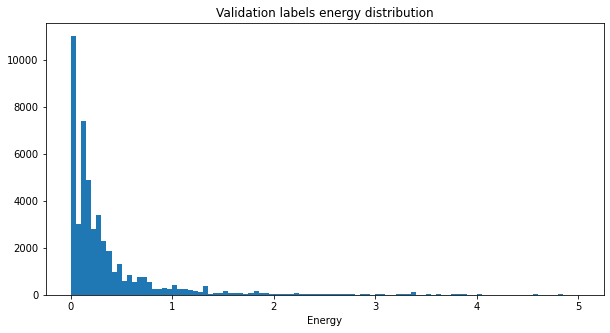

In [10]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [11]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.17353786933730966, Labels' std: 0.7173337594181272
MSE: 0.356
MAE: 0.266


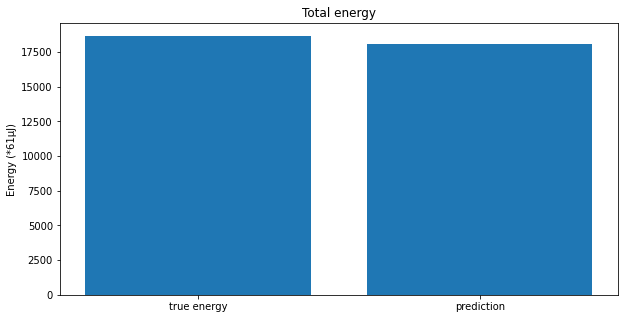

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

## Test programs prediction

In [13]:
maes = {}
prog_energy = {}

for test_program in test_programs:
    prog_df = test_df[test_df.program_name == test_program]
    test_embs = [emb.tolist() for emb in prog_df.bb_embeddings.tolist()]
    test_preds = evaluate.predict(model=model, test_bbs=test_embs)
    true_energies = prog_df.energy.values
    
    maes[test_program] = mean_absolute_error(true_energies, test_preds)
    prog_energy[test_program] = {
        "true_energy": sum(true_energies),
        "pred_energy": sum(test_preds),
    }

In [14]:
maes

{'polinominal_results': 0.23597924982728602,
 'time_results': 0.41957817876086173,
 'ip_results': 0.17782406817265645}

# Simple Model

## Optuna Trials

In [15]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "simple-regression-study"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/palmtee-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Max instructions", 20)
study.set_user_attr("Training-val data", len(train_val_df))
study.set_user_attr("Testing programs", test_programs.tolist())

[I 2023-02-11 01:30:05,047] A new study created in RDB with name: simple-regression-study


A new study created in RDB with name: simple-regression-study


In [16]:
def objective(trial):

    num_layers = trial.suggest_int("dense_layers", 1, 6)
    dense_layers = [trial.suggest_int(f"dense_{i}", 8, 256) for i in range(num_layers)]
    batch_size = trial.suggest_int("batch_size", 128, 768)
    lr = trial.suggest_float("lr", 5e-4, 1e-2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    regressor_dropout = trial.suggest_float("regressor_dropout", 0, 0.15)

    data_loaders = data_utils.get_data_dict(
        data_df=data_df,
        enc_type="palmtree",
        mean=True,
        batch_size=batch_size
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.Simple_Regressor(
        embedding_size=embedding_size,
        layers=dense_layers,
        dropout=dropout,
        regressor_dropout=regressor_dropout,
    )

    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=50,
        batch_size=batch_size,
        early_stopping=True,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=50)

[I 2023-02-11 01:31:03,096] Trial 0 finished with value: 0.6812440853753536 and parameters: {'dense_layers': 4, 'dense_0': 107, 'dense_1': 48, 'dense_2': 103, 'dense_3': 25, 'batch_size': 403, 'lr': 0.0014526000108666974, 'dropout': 0.038552761862757384, 'regressor_dropout': 0.08387859380436752}. Best is trial 0 with value: 0.6812440853753536.


Trial 0 finished with value: 0.6812440853753536 and parameters: {'dense_layers': 4, 'dense_0': 107, 'dense_1': 48, 'dense_2': 103, 'dense_3': 25, 'batch_size': 403, 'lr': 0.0014526000108666974, 'dropout': 0.038552761862757384, 'regressor_dropout': 0.08387859380436752}. Best is trial 0 with value: 0.6812440853753536.


[I 2023-02-11 01:32:32,764] Trial 1 finished with value: 0.657936811787094 and parameters: {'dense_layers': 4, 'dense_0': 45, 'dense_1': 38, 'dense_2': 206, 'dense_3': 227, 'batch_size': 213, 'lr': 0.00627658549736276, 'dropout': 0.022200777199212055, 'regressor_dropout': 0.1337007450414395}. Best is trial 1 with value: 0.657936811787094.


Trial 1 finished with value: 0.657936811787094 and parameters: {'dense_layers': 4, 'dense_0': 45, 'dense_1': 38, 'dense_2': 206, 'dense_3': 227, 'batch_size': 213, 'lr': 0.00627658549736276, 'dropout': 0.022200777199212055, 'regressor_dropout': 0.1337007450414395}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:33:20,093] Trial 2 finished with value: 0.6775010684390127 and parameters: {'dense_layers': 5, 'dense_0': 16, 'dense_1': 68, 'dense_2': 84, 'dense_3': 110, 'dense_4': 70, 'batch_size': 693, 'lr': 0.006174358418085503, 'dropout': 0.15012734379912035, 'regressor_dropout': 0.11186609842506355}. Best is trial 1 with value: 0.657936811787094.


Trial 2 finished with value: 0.6775010684390127 and parameters: {'dense_layers': 5, 'dense_0': 16, 'dense_1': 68, 'dense_2': 84, 'dense_3': 110, 'dense_4': 70, 'batch_size': 693, 'lr': 0.006174358418085503, 'dropout': 0.15012734379912035, 'regressor_dropout': 0.11186609842506355}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:34:04,797] Trial 3 finished with value: 0.669914286956191 and parameters: {'dense_layers': 6, 'dense_0': 118, 'dense_1': 111, 'dense_2': 120, 'dense_3': 219, 'dense_4': 9, 'dense_5': 57, 'batch_size': 699, 'lr': 0.009627597292800156, 'dropout': 0.1089475331707788, 'regressor_dropout': 0.1436287968922219}. Best is trial 1 with value: 0.657936811787094.


Trial 3 finished with value: 0.669914286956191 and parameters: {'dense_layers': 6, 'dense_0': 118, 'dense_1': 111, 'dense_2': 120, 'dense_3': 219, 'dense_4': 9, 'dense_5': 57, 'batch_size': 699, 'lr': 0.009627597292800156, 'dropout': 0.1089475331707788, 'regressor_dropout': 0.1436287968922219}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:34:57,080] Trial 4 finished with value: 0.6698763294547212 and parameters: {'dense_layers': 6, 'dense_0': 38, 'dense_1': 146, 'dense_2': 117, 'dense_3': 31, 'dense_4': 221, 'dense_5': 152, 'batch_size': 546, 'lr': 0.004752849725526307, 'dropout': 0.05642297432449428, 'regressor_dropout': 0.023429202127130143}. Best is trial 1 with value: 0.657936811787094.


Trial 4 finished with value: 0.6698763294547212 and parameters: {'dense_layers': 6, 'dense_0': 38, 'dense_1': 146, 'dense_2': 117, 'dense_3': 31, 'dense_4': 221, 'dense_5': 152, 'batch_size': 546, 'lr': 0.004752849725526307, 'dropout': 0.05642297432449428, 'regressor_dropout': 0.023429202127130143}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:36:38,717] Trial 5 finished with value: 0.6869377672672272 and parameters: {'dense_layers': 6, 'dense_0': 175, 'dense_1': 75, 'dense_2': 175, 'dense_3': 205, 'dense_4': 28, 'dense_5': 171, 'batch_size': 224, 'lr': 0.001031020044391775, 'dropout': 0.195023227556878, 'regressor_dropout': 0.11270555051122551}. Best is trial 1 with value: 0.657936811787094.


Trial 5 finished with value: 0.6869377672672272 and parameters: {'dense_layers': 6, 'dense_0': 175, 'dense_1': 75, 'dense_2': 175, 'dense_3': 205, 'dense_4': 28, 'dense_5': 171, 'batch_size': 224, 'lr': 0.001031020044391775, 'dropout': 0.195023227556878, 'regressor_dropout': 0.11270555051122551}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:38:06,240] Trial 6 finished with value: 0.6854037600546027 and parameters: {'dense_layers': 6, 'dense_0': 122, 'dense_1': 174, 'dense_2': 27, 'dense_3': 192, 'dense_4': 144, 'dense_5': 248, 'batch_size': 282, 'lr': 0.003641824780664956, 'dropout': 0.14782196800486533, 'regressor_dropout': 0.009774228260532541}. Best is trial 1 with value: 0.657936811787094.


Trial 6 finished with value: 0.6854037600546027 and parameters: {'dense_layers': 6, 'dense_0': 122, 'dense_1': 174, 'dense_2': 27, 'dense_3': 192, 'dense_4': 144, 'dense_5': 248, 'batch_size': 282, 'lr': 0.003641824780664956, 'dropout': 0.14782196800486533, 'regressor_dropout': 0.009774228260532541}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:39:39,624] Trial 7 finished with value: 0.6763421913584926 and parameters: {'dense_layers': 6, 'dense_0': 220, 'dense_1': 154, 'dense_2': 256, 'dense_3': 187, 'dense_4': 226, 'dense_5': 63, 'batch_size': 241, 'lr': 0.007614909346591951, 'dropout': 0.1958622510670756, 'regressor_dropout': 0.11004798138022602}. Best is trial 1 with value: 0.657936811787094.


Trial 7 finished with value: 0.6763421913584926 and parameters: {'dense_layers': 6, 'dense_0': 220, 'dense_1': 154, 'dense_2': 256, 'dense_3': 187, 'dense_4': 226, 'dense_5': 63, 'batch_size': 241, 'lr': 0.007614909346591951, 'dropout': 0.1958622510670756, 'regressor_dropout': 0.11004798138022602}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:42:29,664] Trial 8 finished with value: 0.6665331678731101 and parameters: {'dense_layers': 5, 'dense_0': 170, 'dense_1': 213, 'dense_2': 167, 'dense_3': 222, 'dense_4': 250, 'batch_size': 205, 'lr': 0.008577409824264293, 'dropout': 0.13234363125239543, 'regressor_dropout': 0.09052649997973447}. Best is trial 1 with value: 0.657936811787094.


Trial 8 finished with value: 0.6665331678731101 and parameters: {'dense_layers': 5, 'dense_0': 170, 'dense_1': 213, 'dense_2': 167, 'dense_3': 222, 'dense_4': 250, 'batch_size': 205, 'lr': 0.008577409824264293, 'dropout': 0.13234363125239543, 'regressor_dropout': 0.09052649997973447}. Best is trial 1 with value: 0.657936811787094.


[I 2023-02-11 01:44:35,350] Trial 9 finished with value: 0.6554370470861397 and parameters: {'dense_layers': 2, 'dense_0': 251, 'dense_1': 231, 'batch_size': 278, 'lr': 0.007646948688035544, 'dropout': 0.1589160949388, 'regressor_dropout': 0.05983763688370434}. Best is trial 9 with value: 0.6554370470861397.


Trial 9 finished with value: 0.6554370470861397 and parameters: {'dense_layers': 2, 'dense_0': 251, 'dense_1': 231, 'batch_size': 278, 'lr': 0.007646948688035544, 'dropout': 0.1589160949388, 'regressor_dropout': 0.05983763688370434}. Best is trial 9 with value: 0.6554370470861397.


[I 2023-02-11 01:46:15,799] Trial 10 finished with value: 0.6331564717584377 and parameters: {'dense_layers': 1, 'dense_0': 251, 'batch_size': 404, 'lr': 0.009910054112593675, 'dropout': 0.08153111259918144, 'regressor_dropout': 0.05260141038272409}. Best is trial 10 with value: 0.6331564717584377.


Trial 10 finished with value: 0.6331564717584377 and parameters: {'dense_layers': 1, 'dense_0': 251, 'batch_size': 404, 'lr': 0.009910054112593675, 'dropout': 0.08153111259918144, 'regressor_dropout': 0.05260141038272409}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:47:07,703] Trial 11 finished with value: 0.6532531034696353 and parameters: {'dense_layers': 1, 'dense_0': 254, 'batch_size': 391, 'lr': 0.009557930516014987, 'dropout': 0.07608717466269524, 'regressor_dropout': 0.0511179935007209}. Best is trial 10 with value: 0.6331564717584377.


Trial 11 finished with value: 0.6532531034696353 and parameters: {'dense_layers': 1, 'dense_0': 254, 'batch_size': 391, 'lr': 0.009557930516014987, 'dropout': 0.07608717466269524, 'regressor_dropout': 0.0511179935007209}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:48:53,184] Trial 12 finished with value: 0.6394900510939516 and parameters: {'dense_layers': 1, 'dense_0': 247, 'batch_size': 435, 'lr': 0.009764584823222976, 'dropout': 0.07274218008308016, 'regressor_dropout': 0.0469340014677276}. Best is trial 10 with value: 0.6331564717584377.


Trial 12 finished with value: 0.6394900510939516 and parameters: {'dense_layers': 1, 'dense_0': 247, 'batch_size': 435, 'lr': 0.009764584823222976, 'dropout': 0.07274218008308016, 'regressor_dropout': 0.0469340014677276}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:49:55,423] Trial 13 finished with value: 0.6598032683429151 and parameters: {'dense_layers': 1, 'dense_0': 208, 'batch_size': 554, 'lr': 0.009898726342702746, 'dropout': 0.0024415448690043168, 'regressor_dropout': 0.04023064604195994}. Best is trial 10 with value: 0.6331564717584377.


Trial 13 finished with value: 0.6598032683429151 and parameters: {'dense_layers': 1, 'dense_0': 208, 'batch_size': 554, 'lr': 0.009898726342702746, 'dropout': 0.0024415448690043168, 'regressor_dropout': 0.04023064604195994}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:50:36,678] Trial 14 finished with value: 0.6415831471482912 and parameters: {'dense_layers': 2, 'dense_0': 208, 'dense_1': 98, 'batch_size': 517, 'lr': 0.008564861193643228, 'dropout': 0.06783609241934611, 'regressor_dropout': 0.06639242002994368}. Best is trial 10 with value: 0.6331564717584377.


Trial 14 finished with value: 0.6415831471482912 and parameters: {'dense_layers': 2, 'dense_0': 208, 'dense_1': 98, 'batch_size': 517, 'lr': 0.008564861193643228, 'dropout': 0.06783609241934611, 'regressor_dropout': 0.06639242002994368}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:51:29,758] Trial 15 finished with value: 0.6422645833343268 and parameters: {'dense_layers': 2, 'dense_0': 167, 'dense_1': 195, 'batch_size': 351, 'lr': 0.009893544804446548, 'dropout': 0.10029646834606842, 'regressor_dropout': 0.036491593895780244}. Best is trial 10 with value: 0.6331564717584377.


Trial 15 finished with value: 0.6422645833343268 and parameters: {'dense_layers': 2, 'dense_0': 167, 'dense_1': 195, 'batch_size': 351, 'lr': 0.009893544804446548, 'dropout': 0.10029646834606842, 'regressor_dropout': 0.036491593895780244}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:52:18,450] Trial 16 finished with value: 0.6587233462333679 and parameters: {'dense_layers': 3, 'dense_0': 234, 'dense_1': 254, 'dense_2': 33, 'batch_size': 446, 'lr': 0.008385113212036012, 'dropout': 0.08451860313381229, 'regressor_dropout': 5.4121831378720064e-05}. Best is trial 10 with value: 0.6331564717584377.


Trial 16 finished with value: 0.6587233462333679 and parameters: {'dense_layers': 3, 'dense_0': 234, 'dense_1': 254, 'dense_2': 33, 'batch_size': 446, 'lr': 0.008385113212036012, 'dropout': 0.08451860313381229, 'regressor_dropout': 5.4121831378720064e-05}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:53:15,852] Trial 17 finished with value: 0.6620279488464197 and parameters: {'dense_layers': 1, 'dense_0': 80, 'batch_size': 467, 'lr': 0.007229569600789404, 'dropout': 0.04781283029989765, 'regressor_dropout': 0.0724609279621676}. Best is trial 10 with value: 0.6331564717584377.


Trial 17 finished with value: 0.6620279488464197 and parameters: {'dense_layers': 1, 'dense_0': 80, 'batch_size': 467, 'lr': 0.007229569600789404, 'dropout': 0.04781283029989765, 'regressor_dropout': 0.0724609279621676}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:54:23,953] Trial 18 finished with value: 0.6844149177101837 and parameters: {'dense_layers': 3, 'dense_0': 192, 'dense_1': 23, 'dense_2': 249, 'batch_size': 643, 'lr': 0.008893405018592558, 'dropout': 0.08525690679114706, 'regressor_dropout': 0.042034952651484735}. Best is trial 10 with value: 0.6331564717584377.


Trial 18 finished with value: 0.6844149177101837 and parameters: {'dense_layers': 3, 'dense_0': 192, 'dense_1': 23, 'dense_2': 249, 'batch_size': 643, 'lr': 0.008893405018592558, 'dropout': 0.08525690679114706, 'regressor_dropout': 0.042034952651484735}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:56:07,710] Trial 19 finished with value: 0.6728444690308949 and parameters: {'dense_layers': 2, 'dense_0': 143, 'dense_1': 10, 'batch_size': 139, 'lr': 0.007549546402869419, 'dropout': 0.11183150495193446, 'regressor_dropout': 0.02545272847572666}. Best is trial 10 with value: 0.6331564717584377.


Trial 19 finished with value: 0.6728444690308949 and parameters: {'dense_layers': 2, 'dense_0': 143, 'dense_1': 10, 'batch_size': 139, 'lr': 0.007549546402869419, 'dropout': 0.11183150495193446, 'regressor_dropout': 0.02545272847572666}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:57:31,709] Trial 20 finished with value: 0.6564627543914537 and parameters: {'dense_layers': 1, 'dense_0': 236, 'batch_size': 344, 'lr': 0.00906457234752793, 'dropout': 0.06548967873905956, 'regressor_dropout': 0.05966516031929971}. Best is trial 10 with value: 0.6331564717584377.


Trial 20 finished with value: 0.6564627543914537 and parameters: {'dense_layers': 1, 'dense_0': 236, 'batch_size': 344, 'lr': 0.00906457234752793, 'dropout': 0.06548967873905956, 'regressor_dropout': 0.05966516031929971}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:58:15,361] Trial 21 finished with value: 0.6614246762934185 and parameters: {'dense_layers': 2, 'dense_0': 201, 'dense_1': 111, 'batch_size': 531, 'lr': 0.008576533559861627, 'dropout': 0.07054959882887138, 'regressor_dropout': 0.06954853011835431}. Best is trial 10 with value: 0.6331564717584377.


Trial 21 finished with value: 0.6614246762934185 and parameters: {'dense_layers': 2, 'dense_0': 201, 'dense_1': 111, 'batch_size': 531, 'lr': 0.008576533559861627, 'dropout': 0.07054959882887138, 'regressor_dropout': 0.06954853011835431}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 01:58:56,257] Trial 22 finished with value: 0.6409927741340969 and parameters: {'dense_layers': 1, 'dense_0': 225, 'batch_size': 488, 'lr': 0.009907650711558035, 'dropout': 0.042987559292853375, 'regressor_dropout': 0.05502771157081687}. Best is trial 10 with value: 0.6331564717584377.


Trial 22 finished with value: 0.6409927741340969 and parameters: {'dense_layers': 1, 'dense_0': 225, 'batch_size': 488, 'lr': 0.009907650711558035, 'dropout': 0.042987559292853375, 'regressor_dropout': 0.05502771157081687}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:01:04,101] Trial 23 finished with value: 0.6410570034514302 and parameters: {'dense_layers': 1, 'dense_0': 228, 'batch_size': 606, 'lr': 0.009922691240960554, 'dropout': 0.04755001948110898, 'regressor_dropout': 0.05123949763439557}. Best is trial 10 with value: 0.6331564717584377.


Trial 23 finished with value: 0.6410570034514302 and parameters: {'dense_layers': 1, 'dense_0': 228, 'batch_size': 606, 'lr': 0.009922691240960554, 'dropout': 0.04755001948110898, 'regressor_dropout': 0.05123949763439557}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:01:49,465] Trial 24 finished with value: 0.6499019767355732 and parameters: {'dense_layers': 1, 'dense_0': 255, 'batch_size': 439, 'lr': 0.009173350350322258, 'dropout': 0.028388308443805486, 'regressor_dropout': 0.052557217812615645}. Best is trial 10 with value: 0.6331564717584377.


Trial 24 finished with value: 0.6499019767355732 and parameters: {'dense_layers': 1, 'dense_0': 255, 'batch_size': 439, 'lr': 0.009173350350322258, 'dropout': 0.028388308443805486, 'regressor_dropout': 0.052557217812615645}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:02:37,496] Trial 25 finished with value: 0.6544239767666521 and parameters: {'dense_layers': 3, 'dense_0': 149, 'dense_1': 181, 'dense_2': 60, 'batch_size': 483, 'lr': 0.008211066958932674, 'dropout': 0.08639278868996475, 'regressor_dropout': 0.0812145651295551}. Best is trial 10 with value: 0.6331564717584377.


Trial 25 finished with value: 0.6544239767666521 and parameters: {'dense_layers': 3, 'dense_0': 149, 'dense_1': 181, 'dense_2': 60, 'batch_size': 483, 'lr': 0.008211066958932674, 'dropout': 0.08639278868996475, 'regressor_dropout': 0.0812145651295551}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:03:42,618] Trial 26 finished with value: 0.6654050676746571 and parameters: {'dense_layers': 2, 'dense_0': 185, 'dense_1': 256, 'batch_size': 593, 'lr': 0.009162211660213092, 'dropout': 0.05973251872338929, 'regressor_dropout': 0.028884001690431482}. Best is trial 10 with value: 0.6331564717584377.


Trial 26 finished with value: 0.6654050676746571 and parameters: {'dense_layers': 2, 'dense_0': 185, 'dense_1': 256, 'batch_size': 593, 'lr': 0.009162211660213092, 'dropout': 0.05973251872338929, 'regressor_dropout': 0.028884001690431482}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:05:12,109] Trial 27 finished with value: 0.6405905023217201 and parameters: {'dense_layers': 1, 'dense_0': 219, 'batch_size': 350, 'lr': 0.009981005164098203, 'dropout': 0.036224655109408255, 'regressor_dropout': 0.046070595783358176}. Best is trial 10 with value: 0.6331564717584377.


Trial 27 finished with value: 0.6405905023217201 and parameters: {'dense_layers': 1, 'dense_0': 219, 'batch_size': 350, 'lr': 0.009981005164098203, 'dropout': 0.036224655109408255, 'regressor_dropout': 0.046070595783358176}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:06:05,498] Trial 28 finished with value: 0.644884359232987 and parameters: {'dense_layers': 2, 'dense_0': 238, 'dense_1': 130, 'batch_size': 355, 'lr': 0.009235239980473172, 'dropout': 0.018178554812889366, 'regressor_dropout': 0.04554923375284895}. Best is trial 10 with value: 0.6331564717584377.


Trial 28 finished with value: 0.644884359232987 and parameters: {'dense_layers': 2, 'dense_0': 238, 'dense_1': 130, 'batch_size': 355, 'lr': 0.009235239980473172, 'dropout': 0.018178554812889366, 'regressor_dropout': 0.04554923375284895}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:08:06,806] Trial 29 finished with value: 0.6711933191309977 and parameters: {'dense_layers': 3, 'dense_0': 78, 'dense_1': 73, 'dense_2': 158, 'batch_size': 310, 'lr': 0.00809022436969057, 'dropout': 0.03433687007152316, 'regressor_dropout': 0.03299299355755156}. Best is trial 10 with value: 0.6331564717584377.


Trial 29 finished with value: 0.6711933191309977 and parameters: {'dense_layers': 3, 'dense_0': 78, 'dense_1': 73, 'dense_2': 158, 'batch_size': 310, 'lr': 0.00809022436969057, 'dropout': 0.03433687007152316, 'regressor_dropout': 0.03299299355755156}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:08:59,056] Trial 30 finished with value: 0.6423214944345611 and parameters: {'dense_layers': 1, 'dense_0': 211, 'batch_size': 400, 'lr': 0.00681244418160727, 'dropout': 0.05055070550468371, 'regressor_dropout': 0.01943801372437907}. Best is trial 10 with value: 0.6331564717584377.


Trial 30 finished with value: 0.6423214944345611 and parameters: {'dense_layers': 1, 'dense_0': 211, 'batch_size': 400, 'lr': 0.00681244418160727, 'dropout': 0.05055070550468371, 'regressor_dropout': 0.01943801372437907}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:09:54,781] Trial 31 finished with value: 0.6550079544677454 and parameters: {'dense_layers': 1, 'dense_0': 240, 'batch_size': 410, 'lr': 0.009983766184797634, 'dropout': 0.03941233946711961, 'regressor_dropout': 0.039972268964098695}. Best is trial 10 with value: 0.6331564717584377.


Trial 31 finished with value: 0.6550079544677454 and parameters: {'dense_layers': 1, 'dense_0': 240, 'batch_size': 410, 'lr': 0.009983766184797634, 'dropout': 0.03941233946711961, 'regressor_dropout': 0.039972268964098695}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:10:31,422] Trial 32 finished with value: 0.6446627737724617 and parameters: {'dense_layers': 1, 'dense_0': 219, 'batch_size': 761, 'lr': 0.009089656013391524, 'dropout': 0.03940778760928634, 'regressor_dropout': 0.060341693049452874}. Best is trial 10 with value: 0.6331564717584377.


Trial 32 finished with value: 0.6446627737724617 and parameters: {'dense_layers': 1, 'dense_0': 219, 'batch_size': 761, 'lr': 0.009089656013391524, 'dropout': 0.03940778760928634, 'regressor_dropout': 0.060341693049452874}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:11:15,034] Trial 33 finished with value: 0.650364146295902 and parameters: {'dense_layers': 1, 'dense_0': 194, 'batch_size': 495, 'lr': 0.009428648510262577, 'dropout': 0.019858184255271593, 'regressor_dropout': 0.050894885796258636}. Best is trial 10 with value: 0.6331564717584377.


Trial 33 finished with value: 0.650364146295902 and parameters: {'dense_layers': 1, 'dense_0': 194, 'batch_size': 495, 'lr': 0.009428648510262577, 'dropout': 0.019858184255271593, 'regressor_dropout': 0.050894885796258636}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:12:03,479] Trial 34 finished with value: 0.6588769198860973 and parameters: {'dense_layers': 2, 'dense_0': 220, 'dense_1': 219, 'batch_size': 438, 'lr': 0.009976487180951085, 'dropout': 0.058178020533954086, 'regressor_dropout': 0.07773343616232431}. Best is trial 10 with value: 0.6331564717584377.


Trial 34 finished with value: 0.6588769198860973 and parameters: {'dense_layers': 2, 'dense_0': 220, 'dense_1': 219, 'batch_size': 438, 'lr': 0.009976487180951085, 'dropout': 0.058178020533954086, 'regressor_dropout': 0.07773343616232431}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:13:23,024] Trial 35 finished with value: 0.6392591832081477 and parameters: {'dense_layers': 1, 'dense_0': 245, 'batch_size': 372, 'lr': 0.007943827127125972, 'dropout': 0.0753925946495352, 'regressor_dropout': 0.0333310803122515}. Best is trial 10 with value: 0.6331564717584377.


Trial 35 finished with value: 0.6392591832081477 and parameters: {'dense_layers': 1, 'dense_0': 245, 'batch_size': 372, 'lr': 0.007943827127125972, 'dropout': 0.0753925946495352, 'regressor_dropout': 0.0333310803122515}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:14:59,458] Trial 36 finished with value: 0.6668635075156754 and parameters: {'dense_layers': 4, 'dense_0': 243, 'dense_1': 162, 'dense_2': 220, 'dense_3': 109, 'batch_size': 378, 'lr': 0.008858108895987081, 'dropout': 0.07764369302726998, 'regressor_dropout': 0.032655612656966565}. Best is trial 10 with value: 0.6331564717584377.


Trial 36 finished with value: 0.6668635075156754 and parameters: {'dense_layers': 4, 'dense_0': 243, 'dense_1': 162, 'dense_2': 220, 'dense_3': 109, 'batch_size': 378, 'lr': 0.008858108895987081, 'dropout': 0.07764369302726998, 'regressor_dropout': 0.032655612656966565}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:15:55,632] Trial 37 finished with value: 0.6594112916181316 and parameters: {'dense_layers': 2, 'dense_0': 256, 'dense_1': 128, 'batch_size': 317, 'lr': 0.006289817011530053, 'dropout': 0.05806629082868017, 'regressor_dropout': 0.018358739670883736}. Best is trial 10 with value: 0.6331564717584377.


Trial 37 finished with value: 0.6594112916181316 and parameters: {'dense_layers': 2, 'dense_0': 256, 'dense_1': 128, 'batch_size': 317, 'lr': 0.006289817011530053, 'dropout': 0.05806629082868017, 'regressor_dropout': 0.018358739670883736}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:18:40,329] Trial 38 finished with value: 0.6836994236932611 and parameters: {'dense_layers': 5, 'dense_0': 156, 'dense_1': 197, 'dense_2': 12, 'dense_3': 66, 'dense_4': 148, 'batch_size': 264, 'lr': 0.009367290567683468, 'dropout': 0.09130303745743731, 'regressor_dropout': 0.033058941726350974}. Best is trial 10 with value: 0.6331564717584377.


Trial 38 finished with value: 0.6836994236932611 and parameters: {'dense_layers': 5, 'dense_0': 156, 'dense_1': 197, 'dense_2': 12, 'dense_3': 66, 'dense_4': 148, 'batch_size': 264, 'lr': 0.009367290567683468, 'dropout': 0.09130303745743731, 'regressor_dropout': 0.033058941726350974}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:19:33,155] Trial 39 finished with value: 0.6497254971095494 and parameters: {'dense_layers': 1, 'dense_0': 186, 'batch_size': 320, 'lr': 0.007973108719409159, 'dropout': 0.07140422844731256, 'regressor_dropout': 0.04387460493406295}. Best is trial 10 with value: 0.6331564717584377.


Trial 39 finished with value: 0.6497254971095494 and parameters: {'dense_layers': 1, 'dense_0': 186, 'batch_size': 320, 'lr': 0.007973108719409159, 'dropout': 0.07140422844731256, 'regressor_dropout': 0.04387460493406295}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:21:11,788] Trial 40 finished with value: 0.6669021866370722 and parameters: {'dense_layers': 4, 'dense_0': 20, 'dense_1': 92, 'dense_2': 63, 'dense_3': 146, 'batch_size': 193, 'lr': 0.008621766402057649, 'dropout': 0.059443271213714705, 'regressor_dropout': 0.02354061620170013}. Best is trial 10 with value: 0.6331564717584377.


Trial 40 finished with value: 0.6669021866370722 and parameters: {'dense_layers': 4, 'dense_0': 20, 'dense_1': 92, 'dense_2': 63, 'dense_3': 146, 'batch_size': 193, 'lr': 0.008621766402057649, 'dropout': 0.059443271213714705, 'regressor_dropout': 0.02354061620170013}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:22:26,016] Trial 41 finished with value: 0.655175278072848 and parameters: {'dense_layers': 1, 'dense_0': 222, 'batch_size': 411, 'lr': 0.009490397677079616, 'dropout': 0.04539712295429407, 'regressor_dropout': 0.05724651572753223}. Best is trial 10 with value: 0.6331564717584377.


Trial 41 finished with value: 0.655175278072848 and parameters: {'dense_layers': 1, 'dense_0': 222, 'batch_size': 411, 'lr': 0.009490397677079616, 'dropout': 0.04539712295429407, 'regressor_dropout': 0.05724651572753223}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:23:59,557] Trial 42 finished with value: 0.6428293508140981 and parameters: {'dense_layers': 1, 'dense_0': 245, 'batch_size': 469, 'lr': 0.00953545343140209, 'dropout': 0.09769429732368426, 'regressor_dropout': 0.04576906761272477}. Best is trial 10 with value: 0.6331564717584377.


Trial 42 finished with value: 0.6428293508140981 and parameters: {'dense_layers': 1, 'dense_0': 245, 'batch_size': 469, 'lr': 0.00953545343140209, 'dropout': 0.09769429732368426, 'regressor_dropout': 0.04576906761272477}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:25:12,055] Trial 43 finished with value: 0.6415056106243425 and parameters: {'dense_layers': 1, 'dense_0': 226, 'batch_size': 428, 'lr': 0.008865134925570008, 'dropout': 0.07183511210645713, 'regressor_dropout': 0.06478007198522366}. Best is trial 10 with value: 0.6331564717584377.


Trial 43 finished with value: 0.6415056106243425 and parameters: {'dense_layers': 1, 'dense_0': 226, 'batch_size': 428, 'lr': 0.008865134925570008, 'dropout': 0.07183511210645713, 'regressor_dropout': 0.06478007198522366}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:25:54,835] Trial 44 finished with value: 0.6676318623998143 and parameters: {'dense_layers': 2, 'dense_0': 95, 'dense_1': 46, 'batch_size': 504, 'lr': 0.008018252992915217, 'dropout': 0.02816209846646959, 'regressor_dropout': 0.05243235822033853}. Best is trial 10 with value: 0.6331564717584377.


Trial 44 finished with value: 0.6676318623998143 and parameters: {'dense_layers': 2, 'dense_0': 95, 'dense_1': 46, 'batch_size': 504, 'lr': 0.008018252992915217, 'dropout': 0.02816209846646959, 'regressor_dropout': 0.05243235822033853}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:26:43,012] Trial 45 finished with value: 0.6349518763138944 and parameters: {'dense_layers': 1, 'dense_0': 214, 'batch_size': 375, 'lr': 0.009606618265126335, 'dropout': 0.05152394964058292, 'regressor_dropout': 0.03765290724356948}. Best is trial 10 with value: 0.6331564717584377.


Trial 45 finished with value: 0.6349518763138944 and parameters: {'dense_layers': 1, 'dense_0': 214, 'batch_size': 375, 'lr': 0.009606618265126335, 'dropout': 0.05152394964058292, 'regressor_dropout': 0.03765290724356948}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:28:03,545] Trial 46 finished with value: 0.6479904507499894 and parameters: {'dense_layers': 1, 'dense_0': 246, 'batch_size': 366, 'lr': 0.009589687951681063, 'dropout': 0.07987069991996795, 'regressor_dropout': 0.03839473546287968}. Best is trial 10 with value: 0.6331564717584377.


Trial 46 finished with value: 0.6479904507499894 and parameters: {'dense_layers': 1, 'dense_0': 246, 'batch_size': 366, 'lr': 0.009589687951681063, 'dropout': 0.07987069991996795, 'regressor_dropout': 0.03839473546287968}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:29:04,059] Trial 47 finished with value: 0.6671506160183956 and parameters: {'dense_layers': 2, 'dense_0': 212, 'dense_1': 58, 'batch_size': 295, 'lr': 0.008511845505519212, 'dropout': 0.054450585102244486, 'regressor_dropout': 0.04578154670240362}. Best is trial 10 with value: 0.6331564717584377.


Trial 47 finished with value: 0.6671506160183956 and parameters: {'dense_layers': 2, 'dense_0': 212, 'dense_1': 58, 'batch_size': 295, 'lr': 0.008511845505519212, 'dropout': 0.054450585102244486, 'regressor_dropout': 0.04578154670240362}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:31:27,553] Trial 48 finished with value: 0.6851587250497606 and parameters: {'dense_layers': 5, 'dense_0': 178, 'dense_1': 239, 'dense_2': 200, 'dense_3': 150, 'dense_4': 92, 'batch_size': 249, 'lr': 0.00958894487372298, 'dropout': 0.06317015735823459, 'regressor_dropout': 0.01302441696456904}. Best is trial 10 with value: 0.6331564717584377.


Trial 48 finished with value: 0.6851587250497606 and parameters: {'dense_layers': 5, 'dense_0': 178, 'dense_1': 239, 'dense_2': 200, 'dense_3': 150, 'dense_4': 92, 'batch_size': 249, 'lr': 0.00958894487372298, 'dropout': 0.06317015735823459, 'regressor_dropout': 0.01302441696456904}. Best is trial 10 with value: 0.6331564717584377.


[I 2023-02-11 02:33:27,829] Trial 49 finished with value: 0.633778028899715 and parameters: {'dense_layers': 1, 'dense_0': 200, 'batch_size': 333, 'lr': 0.005363603891401987, 'dropout': 0.07799013357366157, 'regressor_dropout': 0.02852643380531119}. Best is trial 10 with value: 0.6331564717584377.


Trial 49 finished with value: 0.633778028899715 and parameters: {'dense_layers': 1, 'dense_0': 200, 'batch_size': 333, 'lr': 0.005363603891401987, 'dropout': 0.07799013357366157, 'regressor_dropout': 0.02852643380531119}. Best is trial 10 with value: 0.6331564717584377.


In [17]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_0,params_dense_1,params_dense_2,params_dense_3,params_dense_4,params_dense_5,params_dense_layers,params_dropout,params_lr,params_regressor_dropout,state
10,10,0.633156,2023-02-11 01:44:35.354498,2023-02-11 01:46:15.785910,0 days 00:01:40.431412,404,251,NaN,NaN,NaN,NaN,NaN,1,0.081531,0.009910,0.052601,COMPLETE
49,49,0.633778,2023-02-11 02:31:27.557669,2023-02-11 02:33:27.815056,0 days 00:02:00.257387,333,200,NaN,NaN,NaN,NaN,NaN,1,0.077990,0.005364,0.028526,COMPLETE
45,45,0.634952,2023-02-11 02:25:54.840216,2023-02-11 02:26:42.997601,0 days 00:00:48.157385,375,214,NaN,NaN,NaN,NaN,NaN,1,0.051524,0.009607,0.037653,COMPLETE
35,35,0.639259,2023-02-11 02:12:03.483604,2023-02-11 02:13:23.011526,0 days 00:01:19.527922,372,245,NaN,NaN,NaN,NaN,NaN,1,0.075393,0.007944,0.033331,COMPLETE
12,12,0.639490,2023-02-11 01:47:07.708378,2023-02-11 01:48:53.170574,0 days 00:01:45.462196,435,247,NaN,NaN,NaN,NaN,NaN,1,0.072742,0.009765,0.046934,COMPLETE
27,27,0.640591,2023-02-11 02:03:42.622909,2023-02-11 02:05:12.095612,0 days 00:01:29.472703,350,219,NaN,NaN,NaN,NaN,NaN,1,0.036225,0.009981,0.046071,COMPLETE
22,22,0.640993,2023-02-11 01:58:15.365445,2023-02-11 01:58:56.243883,0 days 00:00:40.878438,488,225,NaN,NaN,NaN,NaN,NaN,1,0.042988,0.009908,0.055028,COMPLETE
23,23,0.641057,2023-02-11 01:58:56.261383,2023-02-11 02:01:04.088663,0 days 00:02:07.827280,606,228,NaN,NaN,NaN,NaN,NaN,1,0.047550,0.009923,0.051239,COMPLETE
43,43,0.641506,2023-02-11 02:23:59.561724,2023-02-11 02:25:12.041935,0 days 00:01:12.480211,428,226,NaN,NaN,NaN,NaN,NaN,1,0.071835,0.008865,0.064780,COMPLETE
14,14,0.641583,2023-02-11 01:49:55.428312,2023-02-11 01:50:36.665852,0 days 00:00:41.237540,517,208,98.0,NaN,NaN,NaN,NaN,2,0.067836,0.008565,0.066392,COMPLETE


In [19]:
print(f"Best simple-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best simple-regressor-model params: {'batch_size': 404, 'dense_0': 251, 'dense_layers': 1, 'dropout': 0.08153111259918144, 'lr': 0.009910054112593675, 'regressor_dropout': 0.05260141038272409}, achieving val RMSE: 0.6331564717584377


## Model Training

In [5]:
batch_size = 404

train_params = {
    "lr": 0.01,
    "epochs": 200,
    "batch_size": batch_size,
    "verbose": True,
    "early_stopping": True,
}

In [6]:
load = False
save = True

exp_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/simple_palmtree_models"

data_loaders = data_utils.get_data_dict(data_df=data_df, enc_type="palmtree", mean=True, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = models.Simple_Regressor(
    embedding_size=embedding_size, layers=[251], regressor_dropout=0.05, dropout = 0.08,
)

if load:
    model.load_state_dict(torch.load(f"{exp_dir}/model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        **train_params
    )
    if save:
        torch.save(model.state_dict(), f"{exp_dir}/init_simple_model/model")
        additional_attributes = {
            "model_params": {"layers": [251], "regressor_dropout": 0.05},
            "train_params": train_params,
            "loss": "RMSE",
            "number of data": len(train_loader)*batch_size,
            "test programs": test_programs.tolist(),
            "train_loss": train_results["train_loss"],
            "val_loss": train_results["val_loss"],
        }
        with open(f"{exp_dir}/init_simple_model/additional_attributes.json", "w") as file:
            json.dump(additional_attributes, file, indent=4)

Epoch: 1/200, RMSE Train Loss: 0.66512, RMSE Val Loss: 0.63818
Epoch: 2/200, RMSE Train Loss: 0.6586, RMSE Val Loss: 0.6388
Epoch: 3/200, RMSE Train Loss: 0.65894, RMSE Val Loss: 0.64028
Epoch: 4/200, RMSE Train Loss: 0.65875, RMSE Val Loss: 0.63764
Epoch: 5/200, RMSE Train Loss: 0.65906, RMSE Val Loss: 0.63788
Epoch: 6/200, RMSE Train Loss: 0.65827, RMSE Val Loss: 0.63817
Epoch: 7/200, RMSE Train Loss: 0.65895, RMSE Val Loss: 0.63933
Epoch: 8/200, RMSE Train Loss: 0.65862, RMSE Val Loss: 0.63897
Epoch: 9/200, RMSE Train Loss: 0.65848, RMSE Val Loss: 0.63822
Epoch: 10/200, RMSE Train Loss: 0.65245, RMSE Val Loss: 0.63805
Epoch: 11/200, RMSE Train Loss: 0.65344, RMSE Val Loss: 0.63687
Epoch: 12/200, RMSE Train Loss: 0.65339, RMSE Val Loss: 0.6368
Epoch: 13/200, RMSE Train Loss: 0.65367, RMSE Val Loss: 0.63735
Epoch: 14/200, RMSE Train Loss: 0.65319, RMSE Val Loss: 0.63732
Epoch: 15/200, RMSE Train Loss: 0.65302, RMSE Val Loss: 0.63698
Epoch: 16/200, RMSE Train Loss: 0.65329, RMSE Val Lo

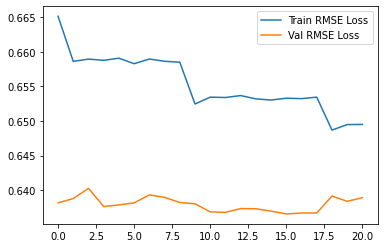

In [7]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

## Evaluation

In [8]:
pred_dict = evaluate.evaluate(model=model, val_loader=val_loader, batch_size=batch_size)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

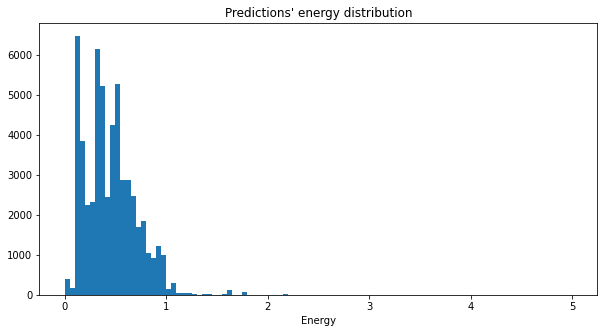

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

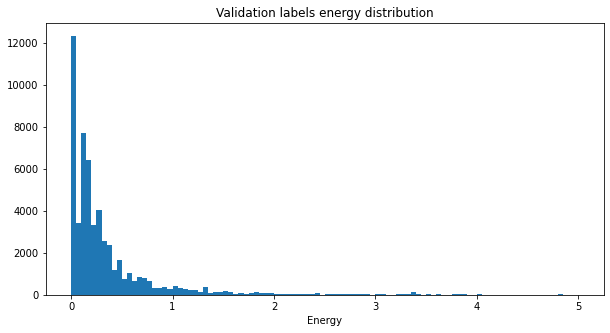

In [10]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [11]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.18474359828785508, Labels' std: 0.7014270361377973
MSE: 0.42
MAE: 0.346


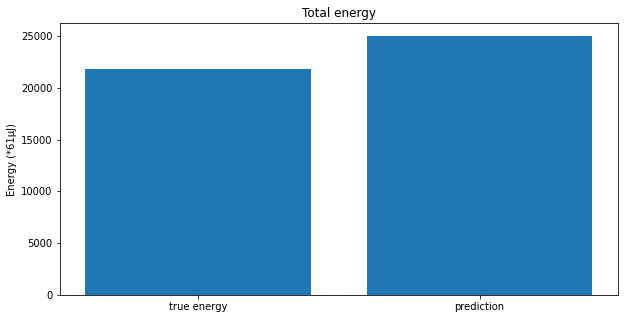

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

## Test programs prediction

In [13]:
from importlib import reload
evaluate=reload(evaluate)

In [14]:
maes = {}
prog_energy = {}

for test_program in test_programs:
    prog_df = test_df[test_df.program_name == test_program]
    test_embs = [emb.tolist() for emb in prog_df.bb_embeddings.tolist()]
    test_preds = evaluate.predict(model=model, test_bbs=test_embs)
    true_energies = prog_df.energy.values
    
    maes[test_program] = mean_absolute_error(true_energies, test_preds)
    prog_energy[test_program] = {
        "true_energy": sum(true_energies),
        "pred_energy": sum(test_preds),
    }

In [15]:
maes

{'bin_to_dec_results': 0.5410858942305344,
 'game_of_life_results': 0.6813707313731611,
 'polinominal_results': 0.2557958293906258}